In [1]:
from torchvision.io.image import read_image
import torch
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import urllib


url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
img = input_image

# Step 1: Initialize model with the best available weights
weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and visualize the prediction
out = model(batch)
prediction = out['out']


In [2]:
batch.shape

torch.Size([1, 3, 520, 649])

In [3]:
type(preprocess)

torchvision.transforms._presets.SemanticSegmentation

In [20]:
import torch
import matplotlib.pyplot as plt
#no batch !!!
output_predictions = prediction[0].argmax(0)
n_classes = prediction[0].shape[0]
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(n_classes)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")
# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)
plt.imshow(r)



KeyboardInterrupt: 

Text(0.5, 1.0, 'Difference (white)')

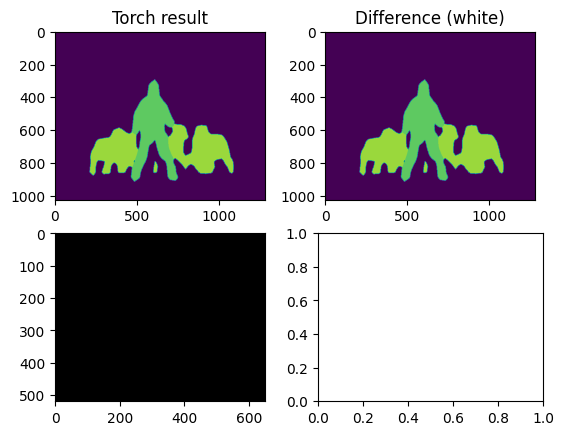

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def prediction_to_image(logits: np.array, outputsize: tuple[int, int] = None) -> np.array:
    output_predictions = logits.argmax(0)
    n_classes = prediction[0].shape[0]
    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([i for i in range(n_classes)])[:, None] * palette
    colors = (colors % 255).astype("uint8")
    colored_image = Image.fromarray(output_predictions.astype(np.uint8))
    if outputsize:
        colored_image = colored_image.resize(outputsize)
    colored_image.putpalette(colors)
    return np.array(r)


def get_compair_image(array1: np.array, array2: np.array) -> np.array:
    mask = np.any(array1 != array2, axis=0)
    # Create an output array for visualization
    visualization_array = np.zeros_like(array1[0], dtype=np.uint8)  # Initialize as black image
    visualization_array[mask] = 255  # Set differing pixels to white (255)
    return visualization_array

temp = prediction[0].detach().cpu().numpy()
i1 = prediction_to_image(temp, input_image.size)


import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(i1)
axes[0,0].set_title('Torch result')

axes[0, 1].imshow(i1)
axes[0,1].set_title('onnx result')

diff_img = get_compair_image(temp, temp)
axes[1, 0].imshow(diff_img, cmap='gray')
axes[0,1].set_title('Difference (white)')



# plt.show()

# output_predictions = prediction[0].argmax(0)
# n_classes = prediction[0].shape[0]
# palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
# colors = np.array([i for i in range(n_classes)])[:, None] * palette
# colors = (colors % 255).astype("uint8")
# # plot the semantic segmentation predictions of 21 classes in each color
# r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
# r.putpalette(colors)
# plt.imshow(r)



In [33]:
temp.shape

(21, 520, 649)

In [99]:
normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["sheep"]]

# to_pil_image(mask).show()

In [100]:
import torch
onnx_model_path = 'model.onnx'
torch.onnx.export(model, batch, onnx_model_path, export_params=True)

In [120]:
torch.cat((batch, batch), dim=0)

torch.Size([2, 3, 520, 649])

In [141]:
import onnxruntime as rt 
import numpy as np
dummy_input = batch
# dummy_input = dummy_input.unsqueeze(0)
dummy_input = torch.cat((dummy_input, dummy_input), dim=0)
dummy_input = dummy_input.cpu().detach().numpy()
dummy_input = dummy_input.astype(np.float32)
sess = rt.InferenceSession(onnx_model_path)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name


In [142]:
dummy_input.shape

(2, 3, 520, 649)

In [143]:
def foo(*args):
    model_input = {x[0].name: x[1] for x in zip(sess.get_inputs(), args)}
    return sess.run([x.name for x in sess.get_outputs()], model_input)
type(foo(dummy_input.astype(np.float32))[1])

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input.1 for the following indices
 index: 0 Got: 2 Expected: 1
 Please fix either the inputs/outputs or the model.

In [140]:
sess.run([label_name], {input_name: dummy_input})[0]

array([[[[ 1.2990669e+01,  1.2990669e+01,  1.2990669e+01, ...,
           1.0583204e+01,  1.0583204e+01,  1.0583204e+01],
         [ 1.2990669e+01,  1.2990669e+01,  1.2990669e+01, ...,
           1.0583204e+01,  1.0583204e+01,  1.0583204e+01],
         [ 1.2990669e+01,  1.2990669e+01,  1.2990669e+01, ...,
           1.0583204e+01,  1.0583204e+01,  1.0583204e+01],
         ...,
         [ 1.3382973e+01,  1.3382973e+01,  1.3382973e+01, ...,
           8.7391405e+00,  8.7391405e+00,  8.7391405e+00],
         [ 1.3382973e+01,  1.3382973e+01,  1.3382973e+01, ...,
           8.7391405e+00,  8.7391405e+00,  8.7391405e+00],
         [ 1.3382973e+01,  1.3382973e+01,  1.3382973e+01, ...,
           8.7391405e+00,  8.7391405e+00,  8.7391405e+00]],

        [[-9.5310062e-01, -9.5310062e-01, -9.5310062e-01, ...,
          -3.1456172e-01, -3.1456172e-01, -3.1456172e-01],
         [-9.5310062e-01, -9.5310062e-01, -9.5310062e-01, ...,
          -3.1456172e-01, -3.1456172e-01, -3.1456172e-01],
        

In [103]:
res = sess.run([label_name], {input_name: dummy_input.astype(np.float32)})[0]


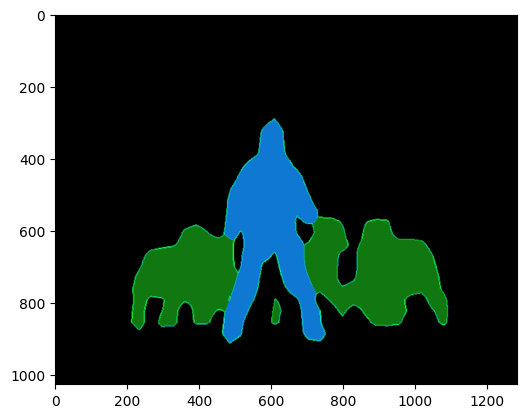

In [73]:
pred_image = res[0].argmax(0)
n_classes = res[0].shape[0]
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(n_classes)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")
# # plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(pred_image.astype(np.uint8)).resize(input_image.size)
r.putpalette(colors)
plt.imshow(r)

In [70]:
output_predictions.byte().cpu().numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [74]:
type(model)

torchvision.models.segmentation.deeplabv3.DeepLabV3

In [75]:
type(sess)

onnxruntime.capi.onnxruntime_inference_collection.InferenceSession

In [82]:
isinstance(sess, rt.capi.onnxruntime_inference_collection.InferenceSession)

True

In [85]:
isinstance(model, torchvision.models.segmentation.deeplabv3.DeepLabV3)

True

In [89]:
isinstance(model, torch.nn.Module)

True

In [152]:

arr = np.array([1,2,3])
type(arr)
isinstance(arr, np.ndarray) 

True